Preparing the dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from keras.datasets import mnist

In [ ]:
import numpy as np


def smooth_curve(x):
    """
     Used to smooth the graph of a loss function
    Reference: http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """
    Perform a shuffle of the dataset
    Parameters
    ----------
    x : training data
    t : Teacher data
    Returns
    -------
    x, t : shuffled training and teacher data
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : input data consisting of a 4D array of (number of data, channel, height, width)
    filter_h : height of the filter
    filter_w : width of the filter
    stride : stride
    pad : padding
    Returns
    -------
    col : 2D array
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : Shape of input data (example)：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

###One-dimensional convolutional neural network scratch

We will build a class of convolutional neural networks (CNNs) from scratch, and implement the algorithms using only minimal libraries such as NumPy.

In this Sprint, we will build a 1D convolutional layer to understand the basics of convolution. In the next sprint, we will create a 2d convolutional layer and a pooling layer to complete a CNN that is commonly used for images.

The name of the class should be Scratch1dCNNClassifier. For the structure of the class, please refer to the ScratchDeepNeuralNetrowkClassifier created in the previous Sprint.

What is 1D convolution layer?
In CNNs, 2-D convolutional layers for images are standard, but for the sake of understanding, we will implement 1-D convolutional layers first. 1-D convolution is often used in practical applications for series data such as natural language or waveform data.

Convolution can be considered for any dimension, and up to 3D convolution for 3D data is commonly available in frameworks.

Preparing the dataset
For the validation we will continue to use the MNIST dataset, which for 1D convolution is a smoothed input as well as an all-connected neural network.

In [ ]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

#print(X_train.shape) # (60000, 28, 28)
#print(X_test.shape) # (10000, 28, 28)
#print(X_train[0].dtype) # uint8
#print(X_train[0])

First of all, make some test data.
1dCNN is often used for time series analysis. For this reason, let's make a simple anomaly detection model as test data.

Since time series anomaly detection systems are often sequential in nature, it is not really necessary to look at every batch like this.

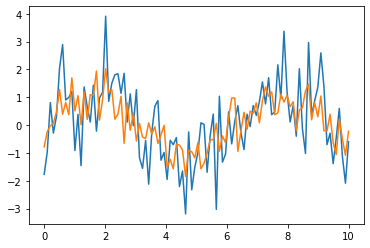

In [ ]:
data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(data_length)    #Outliers have a high variance
nomaly_noise  = np.random.randn(data_length)/2  #Normal values have low variance

#generate time series and labels
t = np.linspace(0,10,data_length)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#Shuffle
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#Drawing
plt.plot(t,x_anomaly[0,:])
plt.plot(t,x_nomaly[0,:])
plt.show()

# [Problem 1] Creating a one-dimensional convolutional layer class that limits the number of channels to one

In [ ]:
class CNN_1d_:
    def __init__(self, p=0, s=1):
        self.padding = p
        self.stride = s
    
    def forward(self, X, filter_size):
        self.X = X
        self.input_size = len(X)
        self.filter_size = filter_size
        self.W = np.random.randint(-2,2,3) 
        self.B = np.array([1])
        # If the input is two-dimensional, calculate HW respectively
        self.output_size = ((self.input_size + self.p*2 - self.filter_size) / self.stride) + 1
        
        
    
    def backward(self):
        pass

In [ ]:
XX = np.random.randint(0, 10, 10)
ww = np.random.randint(-2,2, 3)
print(XX)
print(ww)

[2 8 2 4 2 6 9 1 7 3]
[ 0 -1 -2]


# [Problem 2] Output size calculation after one-dimensional convolution

In [ ]:
def calc_out_shape(Nin, F, P=0, S=1):
    out = ((Nin + 2*P - F) / S ) + 1
    return out

In [ ]:
calc_out_shape(100, 3)

98.0

# [Problem 3] Experiment of one-dimensional convolutional layer with small array

Check that the forward and back propagation is correct with the small array shown below.

Let the input x, the weight w and the bias b be as follows

x = np.array([1,2,3,4])\
w = np.array([3, 5, 7])\
b = np.array([1])\
With forward propagation, the output looks like this

a = np.array([35, 50])\
Now consider backpropagation. Suppose the error is as follows

delta_a = np.array([10, 20])\
If we backpropagate, we get the following value

delta_b = np.array([30])\
delta_w = np.array([50, 80, 110])\
delta_x = np.array([30, 110, 170, 140])\

Implementation considerations\
To implement convolution, you can start with a series of for statements. However, we want to make the computation as efficient as possible, so we will consider a way to compute the following expression at once.

$$ a_i=\Sigma^{F-1}_{s=0}x_{(i+s)}w_s+b $$
The bias term is a simple addition, so we look at the weights part.

$$ \Sigma^{F-1}_{s=0}x_{(i+s)}w_s $$
This is the inner product of an array of w with a part of x taken out of it. Given a concrete situation, we can calculate it with the following code. In this example, to make the flow easier to understand, the adamant product is calculated between each element, and then the sum is calculated. This results in the same as the inner product.

x = np.array([1, 2, 3, 4])\
w = np.array([3, 5, 7])\
a = np.empty((2, 3))\
indexes0 = np.array([0, 1, 2]).astype(np.int)\
indexes1 = np.array([1, 2, 3]).astype(np.int)\
a[0] = x[indexes0]*w # x[indexes0] is ([1, 2, 3])\
a[1] = x[indexes1]*w # x[indexes1] is ([2, 3, 4])\
a = a.sum(axis=1)\
The ndarray method takes advantage of the fact that it is possible to specify indexes using arrays.

You can also use ndarray to get a two-dimensional array out of a one-dimensional array.

x = np.array([1, 2, 3, 4])\
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)\
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])\
With a good combination of this and a broadcast or similar, it is possible to compute them all at once.

There is no right answer to the calculation method of convolution, so you can make it more efficient in your own way.

Reference

The Integer array indexing section of the following page is a description of this method.

In [ ]:
# Samples
x = np.array([1, 2, 3, 4])
y = np.array([45,70])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
a

array([34., 49.])

###[Answer.]

In [ ]:
def Forward(X, W, B=1, P=0, S=1):
    
    lenX = X.shape[0]
    lenW = W.shape[0]
    
    Nout = lenX - lenW +1

    index_list = np.zeros((Nout, lenW)).astype(np.int)

    for i in range(Nout):
        index_list[i] = (np.arange(i, lenW + i ))

    output = np.dot(X[index_list], W) + B
    
    return output

def cross_entropy_loss(pred, label):
    return label - pred
    
def backward(lr, X, W, loss):
    lenX = X.shape[0]
    lenW = W.shape[0]
    
    Nout = lenX - lenW +1

    index_list = np.zeros((Nout, lenW)).astype(np.int)

    for i in range(Nout):
        index_list[i] = (np.arange(i, lenW + i ))
        
        
    dB = np.sum(loss)
    dW = np.dot(loss, X[index_list])

    dX = np.zeros((lenX,))
    for i,index in enumerate(index_list):
        dX[index] += loss[i] * W
        print(dX)
                
            
    #print(dX)
    return dW, dB, dX

In [ ]:
pred = Forward(x,w)
loss = cross_entropy_loss(pred, y)
dW, dB, dX = backward(0.01,x,w,loss)

[30. 50. 70.  0.]
[ 30. 110. 170. 140.]


In [ ]:
print("forward_result : {}".format(pred))
print("loss : {}".format(loss))
print("backward_result")
print("delta_b : {}".format(dB))
print("delta_w : {}".format(dW))
print("delta_x : {}".format(dX))

forward_result : [35 50]
loss : [10 20]
backward_result
delta_b : 30
delta_w : [ 50  80 110]
delta_x : [ 30. 110. 170. 140.]


# [Problem 4] Creating a one-dimensional convolutional layer class that does not limit the number of channels

In [ ]:
xx = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)and (number of input channels, number of features).
ww = np.ones((3, 2, 3)) # All are set to 1 to simplify the example. (number of output channels, number of input channels, filter size).
bb = np.array([1, 2, 3]) # (number of output channels)

In [ ]:
#xx = np.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]]) # shape(2, 4), with (number of input channels, number of features).
#ww = np.ones((4, 3, 3)) # all 1 for simplicity of the example. (number of output channels, number of input channels, filter size).
#bb = np.array([1, 2, 3,4]) # (number of output channels).

In [ ]:
class CNN1d:
    def __init__(self,W, B, stride=1, pad=0):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad

    def forward(self, X):
        print(X.shape)
        self.FN, self.C, self.FS = self.W.shape 
        self.C, self.S = X.shape
        #print(self.F, self.FS)
        self.Nout = int(((self.S + 2*self.pad - self.FS) / self.stride) + 1)
        #print(X)
        #print(self.FN)
        
        # Dimensionality reduction of W　W(FN,C,FS) →W(FNC,FS)
        self.reW= self.W.reshape(self.FN,-1).T
        print(self.reW)
        print("reWのshape:\n{}".format(self.reW.shape))
        
        # Create an output empty output.shape=(4,2) ※(S, Nout)
        self.output = np.zeros((self.S,self.Nout))

        #An empty array to expand X openX.shape=(2,6)
        self.openX = np.zeros((self.Nout,self.FN*self.C))
        
        # An empty array to store the index shape=(2,3)
        self.index_list = np.zeros((self.Nout, self.FN)).astype(np.int)
        # We'll put the index number into that array.
        for i in range(self.Nout):
            self.index_list[i] = np.arange(i, self.FN + i )
        
        #ss = np.arange
        
        #This time, we create an array called [[0,1,2],[1,2,3]]
                
        #print("Empty array for output:\n{}\n".format(self.output))
        #print("Preparing X expansion:\n{}\n".format(self.openX)) 
        print("test")
        print(self.openX[:,self.index_list[0]])
        print(X[0])
        
        # enumerate the list of indices and X
        #utilize each index to store the contents of X in openX
        for k,v in enumerate(self.index_list):
            for k2,v2 in enumerate(X):
                #print(k,v,k2,v2)
                if k2 == 0:
                    self.openX[k][v - k] = v2[v]
                elif k2 == 1:
                    self.openX[k][v + len(v) - k] = v2[v]
                else:
                    self.openX[k][v + len(v)*k2 - k] = v2[v]
                
        print(self.openX)
        
        
        # Add B to the dot product of the expanded X and W.
        # (2,6) @ (6, 3) + (3,) = (2,3)
        self.output = np.dot(self.openX, self.reW) + self.B

        #print("Filtered index:\n{}\n".format(self.index_list))
        #print("Expand W into a two-dimensional array:\n{}\n".format(self.reW))        
         
        #print("X into a two-dimensional array:\n{}\n".format(self.openX))
        #print("Output of forward:\n{}\n".format(self.output.T))
        
        # output transposed at the end shape=(3,2)
        return self.output.T
    
    
    def cross_entropy_loss(self, pred, label):
        #print("y:\n{}\n".format(label))
        return label - pred

    def backward(self, X, W, loss):

        # delta_B sums up the loss
        dB = np.sum(loss)
        #print("dB:\n{}\n".format(dB))
        
        # delta_W is the dot product of loss and X (where X is the expansion of the previous forward), reshape to the form W
        dW = np.dot(loss,self.openX).reshape(self.W.shape)
        #print("dW:\n{}\n".format(dW))
        
        # empty array to store delta_X dX.shape=(2,4)
        dX = np.zeros(X.shape)
        #print(dX)

        # Calculate the contents to be stored in delta_X.
        # dot product of W.T and loss (3,2,3) @ (3,2) = (3,2,2) transpose to (2,2,3)
        calc = np.dot(self.W.T, loss).T
        #print(calc)
        #print(calc)
        
        for k,v in enumerate(self.index_list):
            dX[:,v] += calc[k]



        #print(dX)
        return dW, dB, dX

In [ ]:
trap = CNN1d(ww,bb)
dA = trap.forward(xx)
#loss = trap.cross_entropy_loss(pred, yy)
print(dA)
dW, dB, dX = trap.backward(xx,ww,dA)
dW, dB, dX

(2, 4)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
reWのshape:
(6, 3)
test
[[0. 0. 0.]
 [0. 0. 0.]]
[1 2 3 4]
[[1. 2. 3. 2. 3. 4.]
 [2. 3. 4. 3. 4. 5.]]
[[16. 22.]
 [17. 23.]
 [18. 24.]]


(array([[[ 60.,  98., 136.],
         [ 98., 136., 174.]],
 
        [[ 63., 103., 143.],
         [103., 143., 183.]],
 
        [[ 66., 108., 150.],
         [108., 150., 192.]]]), 120.0, array([[ 51., 120., 120.,  69.],
        [ 51., 120., 120.,  69.]]))

# [Problem 5] (Advanced task) Implementing padding

In [ ]:
# permutation
def _padding(X, n):
    return np.pad(X, [(0,0), (n,n), (n,n)]) # [(cb,ca), (hu,hd), (wl,wr)].

# For back propagation
def _padding_rm(X, n):
    return X[:, n:-n, n:-n]

In [ ]:
X = np.arange(30).reshape(1,6,5)
n = 3

print(X)
X_ = _padding(X, n)
print(X_)
X_ = _padding_rm(X_, n)
print(X_)

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]]
[[[ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  1  2  3  4  0  0  0]
  [ 0  0  0  5  6  7  8  9  0  0  0]
  [ 0  0  0 10 11 12 13 14  0  0  0]
  [ 0  0  0 15 16 17 18 19  0  0  0]
  [ 0  0  0 20 21 22 23 24  0  0  0]
  [ 0  0  0 25 26 27 28 29  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]]]
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]]


# [Problem 6] (Advanced task) Response to mini batch

In [ ]:
class GetMiniBatch:
    """
    Iterator to retrieve the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      The correct answer value
    batch_size : int
      batch size
    seed : int
      Seed of random number in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
# Functions in the Conv1d class
def _convolve(X, k, P, S):
    """
    Cyclic operation

    Parameters
    ----------
    X : ndarray of the following form, shape (N, C, L)
      the matrix to be traversed
    k : ndarray of the following form, shape (F, C, Lf)
      the matrix to be traversed
    """
    L = X.shape[-1]
    Lf = k.shape[-1]
    Lo = self._output_size(L, Lf, P, S) 

    # Generate w for Teplitz
    pad = int(L - Lf) # adjust the length of k to X
    k_pad = np.pad(k, [(0,0), (0,0), (0, pad)]) # k(F,C,Lf) → k(F,C,L)
    # Dimensionality reduction
    X_flat = X.reshape(len(X), -1) # X(N,C,L) → X(N,CL)
    k_flat = k_pad.flatten() # k(F,C,L) → k(FCL)
    # generate the Teplitz matrix
    first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))] # first column of Teplitz
    first_row = k_flat # first row of Teplitz  
    toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
    # Get only the row corresponding to the stride
    toep_ = toep[::S]
    # Block the matrix for each filter and recombine vertically
    toep_reorder = np.vstack(np.split(toep_, len(k), axis=1)) #toep(FLo,LC)
    # matrix operation
    output = toep_reorder@X_flat.T  # out(FLo,N)

    return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)

# [Problem 7] (Advance assignment) Arbitrary number of strides

In [ ]:
def convolve(X, k, P, S):
    L = X.shape[-1]
    Lf = k.shape[-1]
    Lo = int((L + 2*P - Lf) / S + 1)

    # Generate w for Teplitz
    pad = int(L - Lf) # adjust the length of k to X
    k_pad = np.pad(k, [(0,0), (0,0), (0, pad)]) # k(F,C,Lf) → k(F,C,L)
    # Dimensionality reduction
    X_flat = X.reshape(len(X), -1) # X(N,C,L) → X(N,CL)
    k_flat = k_pad.flatten() # k(F,C,L) → k(FCL)
    # generate the Teplitz matrix
    first_col = np.r_[k_flat[0], np.zeros(S*(Lo-1))] # first column of Teplitz
    first_row = k_flat # first row of Teplitz  
    toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
    # Get only the row corresponding to the stride
    toep = toep[::S] 
    # Block the matrix for each filter and recombine vertically
    toep_reorder = np.vstack(np.split(toep, len(k), axis=1)) #toep(FLo,LC)
    # matrix operation
    output = toep_reorder@X_flat.T  # out(FLo,N)
    
    return output.T.reshape(len(X), len(k), Lo)

In [ ]:
# Example: Forward propagation (S=2)

X = np.arange(6).reshape(1,1,6) # N,C,L
w = np.arange(2).reshape(1,1,2) # F,C,Lf
S = 2
P = 0
print(X)
print(w)
print(S)
print(P)

Z = convolve(X, w, P, S)
print(Z)

[[[0 1 2 3 4 5]]]
[[[0 1]]]
2
0


NameError: ignored

In [ ]:
# Example: Back propagation (S=2)
dA = Z
Z = X

# dZ calculation
# transpose the matrix to perform the operation on each channel (leaving N and C)
w_ = np.transpose(w, (1,0,2)) # w(F,C,Lf) → w(C,F,Lf)
w_ = np.flip(w_) # flip up/down/left/right
# dilate dA
N, F, Lo = dA.shape
dA_dil = np.zeros((N, F, S*Lo-S+1)) # prepare dilation matrix
dA_dil[... ,::S] = dA
# padding dA_dil
pad = w.shape[-1] - 1
dA_pad = np.pad(dA_dil, [(0,0), (0,0), (pad, pad)]) # padding only L dimension
# cyclic operation
dZ_ = convolve(dA_pad, w_, 0, 1) # dZ(N,C,L)


# dw calculation            
# transpose the matrices (leaving F and C) to perform the operation on each filter
Z_ = np.transpose(Z, (1,0,2))  # Z(N,C,L) → Z(C,N,L)
dA_ = np.transpose(dA_dil, (1,0,2))  # dA(N,F,Lo) → dA(F,N,Lo)
dw_ = np.transpose(convolve(Z_, dA_, 0, 1), (1,0,2))  # dw(C,F,Lf) → dw(F,C,Lf)

print(dw_)
print(dZ_)

# [Problem 8] Learning and estimation

In [ ]:
import time

class SGD:
    def __init__(self):
        pass
        
    def update_dw(self, layer, grad):
        return grad / layer.input.shape[0]
    
    def update_db(self, layer, grad):
        return grad / layer.input.shape[0]
        

class AdaGrad:
    def __init__(self):
        self.Hw = 1e-8
        self.Hb = 1e-8
        
    def update_dw(self, layer, grad):
        self.Hw += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hw)) / layer.input.shape[0]
        
        return grad
    
    def update_db(self, layer, grad):
        self.Hb += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hb)) / layer.input.shape[0]
        
        return grad
        
        
class Conv1d:
    def __init__(self, pad='SAME', stride=1):
        self.pad = pad
        self.stride = stride
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        # Define various shapes and parameters
        L = Z.shape[-1]
        Lf = w.shape[-1]
        S = self.stride
        
        # Padding process
        if self.pad == 'SAME':
            if L % S == 0:
                P = int((Lf - S) / 2)
            else:
                P = int((Lf - L%S) / 2)
            Z = self._padding(Z, P)
        elif self.pad == 'VALID':
            P = 0
        self.P = P
        
        self.A_ = self._convolve(Z, w, P, S) + b.reshape(1, len(b), 1)  # A(N,F,Lo)
        
        return self.A_
    
    def backward(self, Z, w, dA):
        S = self.stride
        
        # dZ calculation
        # transpose the matrix (leaving N and C) to perform the operation on each channel
        w_ = np.transpose(w, (1,0,2)) # w(F,C,Lf) → w(C,F,Lf)
        w_ = np.flip(w_) # flip up/down/left/right
        # dilate dA
        N, F, Lo = dA.shape
        dA_dil = np.zeros((N, F, S*Lo-S+1)) # prepare dilation matrix
        dA_dil[... ,::S] = dA
        # padding dA_dil
        pad = w.shape[-1] - 1
        dA_pad = np.pad(dA_dil, [(0,0), (0,0), (pad, pad)]) # padding only L dimension
        # Cyclic operation
        dZ_ = self._convolve(dA_pad, w_, 0, 1) # dZ(N,C,L)
        # Padding removal
        if self.P == 0:
            self.dZ_ = dZ_
        else:
            self.dZ_ = self._padding_rm(dZ_, self.P)
        
        # dw calculation            
        # transpose the matrices to perform the operation on each filter (leaving F and C)
        Z_ = np.transpose(Z, (1,0,2)) # Z(N,C,L) → Z(C,N,L)
        dA_ = np.transpose(dA_dil, (1,0,2)) # dA(N,F,Lo) → dA(F,N,Lo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_, self.P, 1), (1,0,2)) # dw(C,F,Lf) → dw(F,C,Lf)
        
        # db calculation 
        # sum over all dimensions except F
        self.db_ = np.sum(dA, axis=(0,2)) # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    def _output_size(self, L, Lf, P, S):
        Lo = (L + 2*P - Lf) / S + 1   
        return int(Lo)
    
    def _padding(self, X, n):
        # for forward propagation
        return np.pad(X, [(0,0), (0,0), (n,n)])

    def _padding_rm(self, X, n):
        # for back propagation
        return X[... , n:-n]
    
    def _convolve(self, X, k, P, S):
        L = X.shape[-1].
        Lf = k.shape[-1].
        Lo = self._output_size(L, Lf, P, S) 

        # Generate w for Teplitz
        pad = int(L - Lf) # adjust the length of k to X
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad)]) # k(F,C,Lf) → k(F,C,L)
        # Dimensionality reduction
        X_flat = X.reshape(len(X), -1) # X(N,C,L) → X(N,CL)
        k_flat = k_pad.flatten() # k(F,C,L) → k(FCL)
        # generate the Teplitz matrix
        first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))] # first column of Teplitz
        first_row = k_flat # first row of Teplitz  
        toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
        # Get only the row corresponding to the stride
        toep = toep[::S]. 
        # Block the matrix for each filter and recombine vertically
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1)) #toep(FLo,LC)
        # matrix operation
        output = toep_reorder@X_flat.T  # out(FLo,N)

        return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)
    

class Linear:
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_
        
        
class ReLu:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = np.maximum(A, 0)
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * np.where(self.Z_ > 0, 1, 0)
        
        return self.dA_
    
        
class Softmax:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        # Subtraction of constants to prevent overflow
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        self.dA_ = self.Z_ - y
        
        return self.dA_
    
    
class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,L) → X(N,CL)
    
    def backward(self, dX):
        return dX.reshape(self.shape)
                    
        
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape_self):
        W = self.sigma * np.random.standard_normal(shape_self)
        return W
    
    def B(self, shape_self):
        B = np.random.randn(n_nodes_self)
        return B
    

class XavierInitializer:
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes_prev, shape_self):
        self.sigma = 1 / np.sqrt(np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # Use standard_normal which can take a tuple as an argument
        return W
    
    def B(self, shape_self):
        B = np.random.standard_normal(shape_self)
        return B
    
    
class HeInitializer:
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes_prev, shape_self):
        self.sigma = np.sqrt(2/np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # Use standard_normal which can take a tuple as an argument
        return W
    
    def B(self, shape_self):
        B = np.random.standard_normal(shape_self)
        return B
    
    
class GetMiniBatch:
    """
    Iterator to retrieve the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      The correct answer value
    batch_size : int
      batch size
    seed : int
      Seed of random number in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
            def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
class Layer:
    def __init__(self, combination, activation, 
                 initializer=None, optimizer=None, n_nodes_prev=None, w_shape=None, b_shape=None):
        self.comb = combination
        self.activ = activation
        self.initializer = initializer # Use the initializer method to initialize self.W and self.B
        self.optimizer = optimizer
        self.n_nodes_prev = n_nodes_prev
        self.w_shape = w_shape
        self.b_shape = b_shape
        self.input = None
        self.output = None
        self.prev = None
        self.next = None
        
        if self.initializer:
            self.w = self.initializer.W(self.n_nodes_prev, self.w_shape)
            self.b = self.initializer.B(self.b_shape)
    
    def forward(self, X):
        if self.comb:
            A = self.comb.forward(X, self.w, self.b)
            Z = self.activ.forward(A)

        else:
            Z = self.activ.forward(X)
        
        self.input = X
        self.output = Z
        
        if self.next:
            return self.next.forward(Z)
        else:
            return Z
    
    def backward(self, y, lr):
        if self.comb:
            dA = self.activ.backward(y)
            dZ, dw, db = self.comb.backward(self.input, self.w, dA)
            
            # Parameter update
            self.w -= lr * self.optimizer.update_dw(self, dw)
            self.b -= lr * self.optimizer.update_db(self, db)
            
        else:
            dZ = self.activ.backward(y)
        
        if self.prev:
            self.prev.backward(dZ, lr)
        else:
            pass
    
    
class Scratch1dCNNClassifier:
    def __init__(self, layers, epoch=100, sigma=0.1, lr=0.01, batch_size=100, verbose=False, **kwargs):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.batch_size = batch_size
        self.loss_train = []
        self.loss_val = []

    def _connect_layers(self, layers):
        for i, layer in enumerate(layers): 
            
            if i == 0:
                layer.next = self.layers[i+1]
                
            elif layer == self.layers[-1]:
                layer.prev = self.layers[i-1]
                
            else:
                layer.next = self.layers[i+1]
                layer.prev = self.layers[i-1]
    
    def fit(self, X, y, X_val=None, y_val=None):
        # Create a layer instance
        self._connect_layers(self.layers)    
        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            start = time.time()
            
            # List of losses for each mini batch
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:

                # Forward propagation
                output = self.layers[0].forward(X_mini)
                # Back propagation
                self.layers[-1].backward(y_mini, self.lr)

                loss_batch_t.append(self.cross_entropy(output, y_mini))
            
            # Store the average loss for each epoch in self
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # Estimation of validation data
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    
                    output = self.layers[0].forward(X_mini)
                
                    loss_batch_v.append(self.cross_entropy(output, y_mini))
            
                # Store the average loss for each epoch in self
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)

            end = time.time()
            times.append(end-start)

            # Output of learning progress
            if self.verbose:
                print("Epoch {}: Train Loss {:.4f}, Val Loss {:.4f}".format(i+1, loss_train, loss_val),
                      " --{:.4f}sec".format(np.mean(times)))            
                   
    def predict(self, X):
        output = self.layers[0].forward(X)
        
        return np.argmax(output, axis=1)
        
    def cross_entropy(self, X, y):
        return (-1/len(X)) * np.sum((y*np.log(X)))

In [ ]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Code to download the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Smoothing data
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# Standardise on X
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# ytoone-hot encode
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
# Converting features to 3D
X_train = X_train[:, None, :]
X_val = X_val[:, None, :]
X_test = X_test[:, None, :]

In [ ]:
def plot_loss(model, title='Scratch CNN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [ ]:
# Setting of hyperparameters w(F,C,Lf) b(F)
W1 = np.array((4,1,6)); B1 = 4
W2 = np.array((8,4,6)); B2 = 8
W3 = np.array((16,8,3)); B3 = 16
W4 = np.array((752,188)); B4 = 188
W5 = np.array((188,10)); B5 = 10

# 5-layer network
layer_1 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 784, W1, B1)  # 1,784 to 4,196
layer_2 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 4*196, W2, B2)  # 4,196 to 8,49
layer_3 = Layer(Conv1d(pad='VALID', stride=1), ReLu(), HeInitializer(), AdaGrad(), 8*49, W3, B3)  # 8,49 to 16,47
layer_4 = Layer(None, Flatten())  # 16,47 to 752,
layer_5 = Layer(Linear(), Sigmoid(), XavierInitializer(), AdaGrad(), 752, W4, B4)  # 752, to 188,
output = Layer(Linear(), Softmax(), XavierInitializer(), AdaGrad(), 188, W5, B5)  # 188, to 10,

params = {'epoch': 10, 
          'lr': 0.01,
          'batch_size': 200,
          }

cnn = Scratch1dCNNClassifier(layers=[layer_1, layer_2, layer_3, layer_4, layer_5, output],
                             verbose=True, **params)

cnn.fit(X_train, y_train, X_val, y_val)

pred = cnn.predict(X_test)

print("\nTest Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(cnn)

In [ ]:
# Check estimation results
plt.figure(figsize=(8,8))
for i in range(20):
    pred = cnn.predict(X_test[i][None,...])
    true = y_test[i]
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[i].reshape(28,28), 'gray')
    plt.title('pred {} \ntrue [{}]'.format(pred, true), y=-0.45)
    plt.axis('off')